This program analyzes the network and generates a comparative historgram of the degree distribution for the entire network vs the subnetwork of interest and shows that we have a scale free network in both cases

In [1]:
import pandas as pd
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import igraph as ig
import datetime

In [2]:
def constructPdfData(data, bins, cumulate):
    ret = [];
    numBins = len(bins)
    binsRange = range(0,numBins)
    count = len(data) #total number of tumors with this gene
    #initalize the returned data with 0 counts in all bins
    for i in binsRange:
        ret.append(0)
    
    #go through the expressionData and bin it
    for v in data:
        for i in binsRange:
            if i == 0:
                if v < bins[i+1]: #anything lower then the second bin value is in the first bin
                    ret[i] += 1
            elif i == numBins - 1: #anything equal to or higher then the last bin value is in the last bin
                if v >= bins[i]: 
                    ret[i] += 1
            elif v >= bins[i] and v < bins[i+1]:
                ret[i] += 1
    
    #now normalize it
    for i in binsRange:
        ret[i] = ret[i]/count
        
    #then cumulate it if we want to
    if cumulate:
        for i in range(1,numBins):
            ret[i] = ret[i] + ret[i-1]
        
    return ret 

In [3]:
print('Start ', str(datetime.datetime.now()))
rawLinks = pd.read_csv('data/9606.protein.links.v10.5.txt', delim_whitespace=True)
rawAlias = pd.read_csv('data/9606.protein.aliases.v10.5.txt', delimiter='\t')
print('Files are read in ', str(datetime.datetime.now()))

Start  2019-01-16 22:21:20.082187
Files are read in  2019-01-16 22:21:27.720038


In [4]:
links = list(zip(rawLinks.protein1, rawLinks.protein2))
nodes = pd.unique(rawLinks[['protein1', 'protein2']].values.ravel('K'))
edgeWeights = rawLinks.combined_score;
print('Nodes and links are made ', str(datetime.datetime.now()))
print('Nodes ', len(nodes))
print('Links ', len(links))

Nodes and links are made  2019-01-16 22:21:31.057294
Nodes  19576


In [5]:
g = ig.Graph()
g.add_vertices(nodes)
g.add_edges(links)
g.vs["label"] = g.vs["name"]
print('Graph Strx is built ', str(datetime.datetime.now()))

Graph Strx is built  2019-01-16 22:21:37.299531


In [6]:
#plot a full diagram on the entire network.... don't do this
if False:
    print(str(datetime.datetime.now()))
    layout = g.layout_drl(weights=edgeWeights)
    #g.write_svg('graph.svg', layout = layout, width=25000, height=25000)
    print(str(datetime.datetime.now()))
    ig.plot(g, 'graph.png', layout = layout, bbox = (30000, 30000))
    print(str(datetime.datetime.now()))
    print('done -- open graph.png')
print('done')

done


In [7]:
#load list of gene products we want to compare 
specialGenesProducts = set(pd.read_csv('Diff_1_3_01.txt', header=None)[0])

#build a map of aliases to protein_ids
proteinIdToAlias = {}
aliasToProteinId = {}
for val in list(zip(rawAlias.string_protein_id, rawAlias.alias)):
    aliasToProteinId[val[1]] = val[0]
    if not val[0] in proteinIdToAlias: #the alias file has lots of duplicates!
        proteinIdToAlias[val[0]]=[val[1]]
    else:
        proteinIdToAlias[val[0]].append(val[1])
        
print('Built maps to identify proteins etc')
print(str(datetime.datetime.now()))

Built maps to identify proteins etc
2019-01-16 22:21:39.483832


In [8]:
#sorts the nodes and puts the ones with the highest degree on the top
geneProdDist = []
for v in g.vs:
    geneProdDist.append(tuple([v.degree(), v.attributes()['name']]))

print('Built degree distribution data of gene products across entire network')
print(str(datetime.datetime.now()))

Built degree distribution data of gene products across entire network
2019-01-16 22:21:39.530274


In [9]:
specialGeneProdVals = []
for item in geneProdDist:
    aliasesForItem = proteinIdToAlias[item[1]]
    isSpecial = not specialGenesProducts.isdisjoint(aliasesForItem)
    if isSpecial:
        specialGeneProdVals.append(item[0])
        
print('Filtered degree distribution data of gene products across entire network to just the gene products we care about')
print(str(datetime.datetime.now()))

Filtered degree distribution data of gene products across entire network to just the gene products we care about
2019-01-16 22:21:39.658772


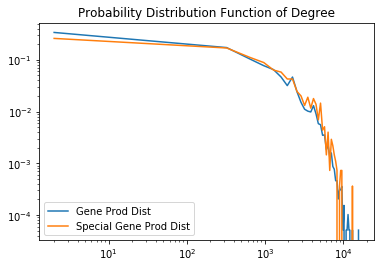

In [11]:
geneProdDistDF = pd.DataFrame(geneProdDist)
minVal = geneProdDistDF[0].min()
maxVal = geneProdDistDF[0].max()
bins = np.linspace(minVal, maxVal, 50)

plt.plot(bins, constructPdfData(geneProdDistDF[0], bins, False), label='Gene Prod Dist')
plt.plot(bins, constructPdfData(specialGeneProdVals, bins, False), label='Special Gene Prod Dist')
plt.title('Probability Distribution Function of Degree')
plt.xscale('log')
plt.yscale('log')
plt.legend()